<a href="https://colab.research.google.com/github/MatteoFusconi/Artificial-Intelligence-master/blob/main/I_assignment_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **_Part-of Speech (POS) tagging_**

**Authors**: Chiara Angileri, Matteo Fusconi, Niccolò Marzi, Shola Oshodi

#### valutare insieme se mettere:
- word listing totali e check oov (non servono in caso si possono fare delle statistiche)
- evaluate voc ? da mettere?
- tags in categorical ?
- pensare insieme se il calcolo di f1 è giusto

## 0. Importing libraries

In [72]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import gensim.downloader as gloader

from collections import OrderedDict
from collections.abc import Callable
from typing import Tuple

from functools import reduce

from keras.preprocessing.sequence import pad_sequences



In [2]:
seed = 42
#seed = 16
#seed = 32


def fix_random(seed):
    """Fix all the possible sources of randomness.
    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(seed)

## 1. Corpus

* **Download** the corpus.

In [3]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

data_folder = os.path.join(os.getcwd(), "data") # directory containing data

def download_and_unzip_dataset():
    """
        Downloads and unzips the dataset for the assignment
    """
    dataset_folder = os.path.join(data_folder, "dependency_treebank")

    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

    if not os.path.exists(dataset_folder):
        print('Downloading and extracting dataset to :', dataset_folder)
        with urlopen(url) as response:
            zipfile = ZipFile(BytesIO(response.read()))
            zipfile.extractall(path=data_folder)
    else :
        print("The dataset has been already downloaded!")

download_and_unzip_dataset()

* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

In [5]:
TRAINING_SPLIT = (1, 101)
VALIDATION_SPLIT = (101,151)
TEST_SPLIT = (151,200)

In [6]:
def encode_corpus(data_folder, dataframe_name):
    """
        Encodes the corpus in a dataframe
    """

    dataset_folder = os.path.join(data_folder, dataframe_name)
    dataframe_rows = []

    for doc in sorted(os.listdir(dataset_folder)):
        doc_num = int(doc[5:8])
        doc_path = os.path.join(dataset_folder,doc)

        with open(doc_path, mode='r', encoding='utf-8') as file:
            df_document = pd.read_csv(file, sep='\t', header=None, skip_blank_lines=False)
            df_document.rename(columns={0: 'word', 1: 'tag'}, inplace=True)
            df_document.drop(2, axis=1, inplace=True)

            df_document["sentence_num"] = df_document.isnull().all(axis=1).cumsum()

            df_document.dropna(inplace=True)
            df_document.reset_index(drop=True, inplace=True)

            #generate sentence list in a document
            df_list = [df_document.iloc[rows] for _, rows in df_document.groupby('sentence_num').groups.items()]
            for n, d in enumerate(df_list) : #for each sentence create a row in the final dataframe
                dataframe_row = {
                    "split" : 'train' if doc_num < TRAINING_SPLIT[1] else ('val' if doc_num < VALIDATION_SPLIT[1] else 'test'),
                    "doc_id" : doc_num,
                    "sentence_id" : n,
                    "words": np.array(d['word'].tolist()),
                    "tags":  np.array(d['tag'].tolist()),
                }
                dataframe_rows.append(dataframe_row)

    df = pd.DataFrame(dataframe_rows)

    return df

df = encode_corpus(data_folder, "dependency_treebank")

In [7]:
# count the number of doc_id in the training set
print('Number of documents in the training set: ', df[df['split'] == 'train']['doc_id'].nunique())

# count the number of doc_id in the validation set
print('Number of documents in the validation set: ', df[df['split'] == 'val']['doc_id'].nunique())

# count the number of doc_id in the test set
print('Number of documents in the test set: ', df[df['split'] == 'test']['doc_id'].nunique())

# Checking the dataframe
df.head(10)

Number of documents in the training set:  100
Number of documents in the validation set:  50
Number of documents in the test set:  49


,split,doc_id,sentence_id,words,tags
0,train,1,0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,train,1,1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,train,2,0,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,train,3,0,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,train,3,1,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
5,train,3,2,"[Lorillard, Inc., ,, the, unit, of, New, York-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD..."
6,train,3,3,"[Although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,..."
7,train,3,4,"[A, Lorillard, spokewoman, said, ,, ``, This, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]"
8,train,3,5,"[We, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ..."
9,train,3,6,"[There, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, ., '']"


## 2. Text encoding

* **Text preprocessing**: *text to lower* -> casing usually doesn't affect our task, but in some scenarios, such as part-of-speech tagging, it is crucial.



In [8]:
def lower(text):
    """
        Transforms given text to lower case.
    """
    lower_text = []

    for word in text:
        if type(word) == np.str_:
            lower_text.append(np.char.lower(word))
        else:
            lower_text.append(word)

    return lower_text

def text_preprocessing(text):
    """
        Applies a lower case transformation to the given text.
    """
    return reduce(lambda txt, f: f(txt), [lower], text)

In [9]:
print('Pre-processing text...')

df['words'] = df['words'].apply(lambda txt: text_preprocessing(txt))

print("Pre-processing completed!")

df.head(10)

Pre-processing text...
Pre-processing completed!


,split,doc_id,sentence_id,words,tags
0,train,1,0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,train,1,1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,train,2,0,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,train,3,0,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,train,3,1,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
5,train,3,2,"[lorillard, inc., ,, the, unit, of, new, york-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD..."
6,train,3,3,"[although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,..."
7,train,3,4,"[a, lorillard, spokewoman, said, ,, ``, this, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]"
8,train,3,5,"[we, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ..."
9,train,3,6,"[there, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, ., '']"


* **Building vocabulary**

In [10]:
def build_vocabulary(df, vocabulary_path = None):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :param vocabulary_path: path to the vocabulary pickle file (string)

    :return:
        - word vocabulary: vocabulary index to word
        - inverse word vocabulary: word to vocabulary index
        - word listing: set of unique terms that build up the vocabulary
        - tag vocabulary: vocabulary index to tag
        - inverse tag vocabulary: tag to vocabulary index
        - tag listing: set of unique tags that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    idx_to_tag = OrderedDict()
    tag_to_idx = OrderedDict()

    # For padding purposes
    word_to_idx['<pad>'] = 0
    idx_to_word[0] = '<pad>'

    # For dealing with unknown words
    word_to_idx['<unk>'] = 1
    idx_to_word[1] = '<unk>'

    curr_idx = 2
    for sentence in tqdm(df.words.values):
        for t in sentence:
            t = str(t)
            if t not in word_to_idx:
                word_to_idx[t] = curr_idx
                idx_to_word[curr_idx] = t
                curr_idx += 1

    word_listing = list(idx_to_word.values())

    # For padding purposes
    tag_to_idx['<pad>'] = 0
    idx_to_tag[0] = '<pad>'

    # For dealing with unknown tags
    tag_to_idx['<unk>'] = 1
    idx_to_tag[1] = '<unk>'

    curr_idx = 2
    for tag in tqdm(df.tags.values):
        for t in tag:
            if t not in tag_to_idx:
                tag_to_idx[t] = curr_idx
                idx_to_tag[curr_idx] = t
                curr_idx += 1

    tag_listing = list(idx_to_tag.values())

    pickle_files = [idx_to_word, word_to_idx, word_listing, idx_to_tag, tag_to_idx, tag_listing]

    if vocabulary_path is not None:
        # Save pickle_files to disk
        with open(vocabulary_path, 'wb') as f:
            pickle.dump(pickle_files, f)

    return idx_to_word, word_to_idx, word_listing, idx_to_tag, tag_to_idx, tag_listing

In [11]:
def load_vocab(df, vocab_path):
    """
        Loads the vocabulary from the given path.
    """
    if os.path.exists(vocab_path):
        print("Loading vocabulary...")
        with open(vocab_path, 'rb') as f:
            idx_to_word, word_to_idx, word_listing, idx_to_tag, tag_to_idx, tag_listing = pickle.load(f)
        print("Vocabulary loaded!")
    else:
        print("Building vocabulary...")
        idx_to_word, word_to_idx, word_listing, idx_to_tag, tag_to_idx, tag_listing = build_vocabulary(df, vocab_path)
        print("\nVocabulary built!")

    return idx_to_word, word_to_idx, word_listing, idx_to_tag, tag_to_idx, tag_listing

In [12]:
# Get the vocabulary
df_train = df[df['split'] == 'train']

folder = os.getcwd()
vocabulary_path = os.path.join(folder, "vocabulary_train.pkl")

idx2word, word2idx, word_listing, idx2tag, tag2idx, tag_listing = load_vocab(df_train, vocabulary_path)

Building vocabulary...


100%|██████████| 1963/1963 [00:00<00:00, 104435.97it/s]


Vocabulary built!


In [13]:
print('Vocabulary size: ', len(word_listing))
print(word_listing[:20])

print('Number of unique tags: ', len(tag_listing))
print(tag_listing[:20])

Vocabulary size:  7406
['<pad>', '<unk>', 'pierre', 'vinken', ',', '61', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.', 'mr.']
Number of unique tags:  47
['<pad>', '<unk>', 'NNP', ',', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', '.', 'VBZ', 'VBG', 'CC', 'VBD', 'VBN', 'RB', 'TO']


* Embed words using **GloVe embeddings**.

In [14]:
def load_embedding_model(embedding_dimension):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model
    """

    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    emb_model = gloader.load(download_path)

    return emb_model

EMBEDDING_DIMENSION = 300 # TODO: we can also try with 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension = EMBEDDING_DIMENSION)

[==================================================] 100.0% 376.1/376.1MB downloaded


* **Embedding matrix** and OOV handling.

In [15]:
def generate_random_static_embedding(embedding_dim):
    '''
    Generates a random static embedding for OOV tokens
    '''
    return np.random.uniform(-0.5, 0.5, size=embedding_dim)

def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, vocab_size):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: size of the embedding space to consider (int)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary (int)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = generate_random_static_embedding(embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [16]:
embedding_matrix = build_embedding_matrix(embedding_model, EMBEDDING_DIMENSION, word2idx, len(word_listing))
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7406/7406 [00:00<00:00, 249988.05it/s]


Embedding matrix shape: (7406, 300)


* **Tokenization**: padding and encoding.

In [17]:
# Encode sentences with their indexes
def encode_sentences_and_tags(df, word_listing_train, tag_listing_train, word_to_idx, tag_to_idx):
    """
        Encodes sentences and tags in the df with their indexes.
    """
    sentences = df.words.values

    encoded_sentences = []
    for sentence in sentences:
        encoded_sentence = []
        for word in sentence:
            word = str(word)
            if (word not in word_listing_train):
              word = '<unk>'
            encoded_sentence.append(word_to_idx[word])
        encoded_sentences.append(encoded_sentence)

    tags = df.tags.values

    encoded_tags = []
    for tag in tags:
        encoded_tag = []
        for t in tag:
            if (t not in tag_listing_train):
                t = '<unk>'
            encoded_tag.append(tag_to_idx[t])
        encoded_tags.append(encoded_tag)

    return encoded_sentences, encoded_tags

encoded_sentences_train, encoded_tags_train = encode_sentences_and_tags(df[df['split'] == 'train'], word_listing, tag_listing, word2idx, tag2idx)
encoded_sentences_val, encoded_tags_val = encode_sentences_and_tags(df[df['split'] == 'val'], word_listing, tag_listing, word2idx, tag2idx)
encoded_sentences_test, encoded_tags_test = encode_sentences_and_tags(df[df['split'] == 'test'], word_listing, tag_listing, word2idx, tag2idx)


* Assessment of **padding dimension** involves an examination of sentence length distributions within the training dataset, with the goal of determining an optimal maximum sequence length for padding.
This seeks to strike a balance between minimizing word truncation in long sentences and controlling the extent of required padding.

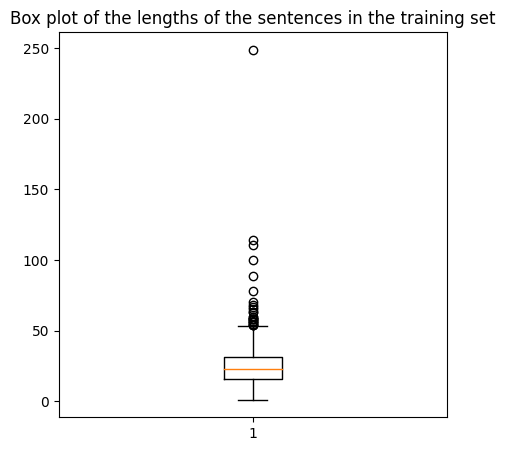

Maximum length of the sentences: 249
Threshold for the maximum length of the sentences: 70
Number of sentences with length greater than 70: 6


In [18]:
# Show the box plot of the lengths of the sentences in the training set
plt.figure(figsize=(5, 5))
lenghts = [len(s) for s in encoded_sentences_train]
max_len = max(lenghts)
plt.boxplot(lenghts)
plt.title('Box plot of the lengths of the sentences in the training set')
plt.show()

# Choose a threshold for the maximum length of the sentences using the quantile
length_thr = int(np.quantile(lenghts, 0.997))
print(f"Maximum length of the sentences: {max_len}")
print(f"Threshold for the maximum length of the sentences: {length_thr}")
print(f'Number of sentences with length greater than {length_thr}: {np.sum([s > length_thr for s in lenghts])}')


In [19]:
def pad_encoded_sentences_and_tags(encoded_sentences, encoded_tags, max_len):
    """
        Pads the encoded sentences and tags.

        :param encoded_sentences: list of encoded sentences (list)
        :param encoded_tags: list of encoded tags (list)
        :param max_len: padding dimension (int)

        :return:
            - padded encoded sentences (numpy.ndarray)
            - padded encoded tags (numpy.ndarray)
    """
    padded_encoded_sentences = pad_sequences(encoded_sentences, padding='post', maxlen=max_len)
    padded_encoded_tags = pad_sequences(encoded_tags, padding='post', maxlen=max_len)
    return padded_encoded_sentences, padded_encoded_tags

MAX_SEQ_LENGTH = length_thr
padded_encoded_sentences_train, padded_encoded_tags_train = pad_encoded_sentences_and_tags(encoded_sentences_train, encoded_tags_train, MAX_SEQ_LENGTH)
padded_encoded_sentences_val, padded_encoded_tags_val = pad_encoded_sentences_and_tags(encoded_sentences_val, encoded_tags_val, MAX_SEQ_LENGTH)
padded_encoded_sentences_test, padded_encoded_tags_test = pad_encoded_sentences_and_tags(encoded_sentences_test, encoded_tags_test, MAX_SEQ_LENGTH)


## 3. Model definition

In [20]:
num_classes = len(tag_listing)

INPUT_SIZE = len(word_listing)
HIDDEN_SIZE = 128 #TODO: si puo provare a cambiare
OUTPUT_SIZE = num_classes

BATCH_SIZE = 16

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [22]:
class DataframeDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        return torch.tensor(sample['words']), torch.tensor(sample['tags'])

train_df = pd.DataFrame([{'words': word, 'tags': tag} for word, tag in zip(padded_encoded_sentences_train, padded_encoded_tags_train)])
val_df = pd.DataFrame([{'words': word, 'tags': tag} for word, tag in zip(padded_encoded_sentences_val, padded_encoded_tags_val)])
test_df = pd.DataFrame([{'words': word, 'tags': tag} for word, tag in zip(padded_encoded_sentences_test, padded_encoded_tags_test)])

train_ds = DataframeDataset(train_df)
val_ds = DataframeDataset(val_df)
test_ds = DataframeDataset(test_df)

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE)

In [23]:
class Custom(nn.Module):
    def __init__(self, input_size, embedding_matrix, hidden_size, output_size, model_type):  #0:base 1:model1 #2:model2
        super(Custom, self).__init__()
        self.input_size = input_size
        self.embedding_matrix = torch.Tensor(embedding_matrix)
        self.pad_idx = 0 #index of the padding token
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.model_type = model_type

        self.embedding = nn.Embedding.from_pretrained(self.embedding_matrix, freeze=True, padding_idx = self.pad_idx)
        embedding_dim = self.embedding_matrix.shape[-1]

        self.lstm = torch.nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)

        # Check the model type
        if self.model_type == 1: #model1 --> add a LSTM layer to the baseline model
            self.lstm1 = torch.nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True) #check size
            self.output = torch.nn.Linear(hidden_size*2, output_size)

        elif self.model_type == 2: #model2 --> add a dense layer to the baseline model
            self.dense = nn.Linear(hidden_size*2, hidden_size)
            self.output = nn.Linear(hidden_size, output_size)

        else: #baseline model
            self.output = torch.nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)

        # Check the model type
        if self.model_type == 1:
            x, _ = self.lstm1(x)
            out = self.output(x)
        elif self.model_type == 2:
            x = self.dense(x)
            out = self.output(x)
        else:
            out = self.output(x)
        # out = F.log_softmax(out, dim=1)
        return out

In [24]:
def compile_models(embedding_matrix, input_size, hidden_size, output_size):
  baseline_model = Custom(input_size, embedding_matrix, hidden_size, output_size, 0).to(device)
  model1 = Custom(input_size, embedding_matrix, hidden_size, output_size, 1).to(device)
  model2 = Custom(input_size, embedding_matrix, hidden_size, output_size, 2).to(device)
  return baseline_model, model1, model2

model_list = compile_models(embedding_matrix= embedding_matrix,
                            input_size= INPUT_SIZE,
                            hidden_size= HIDDEN_SIZE,
                            output_size= OUTPUT_SIZE)

## 4. Metrics

* In order to avoid considering punctuation and symbol classes, we firstly need to inspect which tags are associated to the punctuation and symbol characters.
* Then, we manually select the tags that we want to esclude in the evaluation.

In [26]:
def get_words_by_tag(df):
  """
      Finds the dataframe containing all the words associated to each Part Of Speech
      :param df: training dataframe consisting of the sentences
  """
  tag2words = {}
  for words, tags in zip(df_train["words"], df_train["tags"]):
    for w, t in zip(words, tags):
      if str(w) not in tag2words.get(str(t), []):
        tag2words[str(t)] = tag2words.get(str(t), []) + [str(w)]

  for k, v in tag2words.items():
      tag2words[k] = " / ".join(v)
  return pd.DataFrame(tag2words.values(), index= pd.Index(tag2words.keys()), columns= ["WORDS"])

tag2words = get_words_by_tag(df_train)
print(tag2words)

                                                   WORDS
NNP    pierre / vinken / nov. / mr. / elsevier / n.v....
,                                                 , / wa
CD     61 / 29 / 55 / 30 / 1956 / 1950s / 1953 / 1955...
NNS    years / filters / deaths / workers / researche...
JJ     old / nonexecutive / former / british / indust...
MD     will / should / can / may / could / would / mi...
VB     join / make / bring / be / support / regulate ...
DT     the / a / this / an / any / no / neither / tho...
NN     board / director / chairman / group / conglome...
IN     as / of / among / than / ago / once / with / i...
.                                              . / ? / !
VBZ    is / has / enters / makes / appears / does / '...
VBG    publishing / causing / using / talking / havin...
CC        and / nor / & / but / or / plus / yet / either
VBD    was / reported / said / stopped / were / heard...
VBN    named / used / caused / exposed / reported / r...
RB     once / unusually / even 

In [63]:
PUNCTUATION_PAD = ["<pad>", ",", ".", "``","''", ':', '$', '-LRB-', "-RRB-", 'SYM', '#']
PUNCTUATION_PAD_id = [tag2idx[x] for x in PUNCTUATION_PAD]
print(PUNCTUATION_PAD_id)

[0, 3, 12, 28, 30, 32, 35, 38, 39, 44, 46]


* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)

In [61]:
def evaluate_model(y_true: torch.Tensor, y_pred: torch.Tensor, pad_punctuation_idx: list) -> float:
  """
      Calculates the model's f1 score
      :param y_true: ground truth tensor of padded sentences
      :param y_pred: tensor of predicted padded sentences
      :param idx2tag: dictionary: keys = indeces, values = tags
      :param punctuation: list of tags associated to punctuation and symbols

      :return: f1-score
  """
  # remove padding and punctuation and flatten
  # LA MAPPA VA CALCOLATA SUL GROUND TRUTH O SU QUELLO PREDETTO?
  map = ~torch.isin(y_pred, torch.Tensor(pad_punctuation_idx).to(device))
  y_true = y_true[map].cpu()
  y_pred = y_pred[map].cpu()

  return f1_score(y_true, y_pred, average= "macro")

## 5. Training and Evaluation

Our approach follows this pipeline:
1. We define the functions needed to train and evaluate data
2. We undertake hyperparameter tuning
3. With fine-tuned hyparameters, we repeat the training with different seeds for robust estimation
4. We select the best model

In the notebook it is showed explicitly just one training for each of the models

#### 5.1 Function definitions

In [74]:
def train_loop(model: nn.Module,
               train_dl: DataLoader,
               val_dl: DataLoader,
               epochs: int,
               opt: torch.optim,
               loss_fn: Callable,
               verbose: bool=False) -> None:
  """
    Function for the training loop with validation data
  """
  for e in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0

    for train_sentence, train_tags in train_dl:
      input = train_sentence.to(device)
      labels = train_tags.to(device).long()  # to Long type for the cross entropy

      model.zero_grad()
      opt.zero_grad()

      scores = model(input)  # (batch_size, sequence_length, num_tags)

      # Flatten both the scores and labels to match the expected shape for CrossEntropyLoss
      scores = scores.view(-1, scores.shape[-1])  # (batch_size * sequence_length, num_tags)
      labels = labels.view(-1)  # (batch_size * sequence_length)
      loss = loss_fn(scores, labels)
      loss.backward()
      opt.step()

      train_loss += loss.item()
    train_loss /= len(train_dl)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
      for val_sentence, val_tags in val_dl:
        val_input = val_sentence.to(device)
        val_labels = val_tags.to(device).long()

        val_scores = model(val_input)
        val_scores = val_scores.view(-1, val_scores.shape[-1])
        val_labels = val_labels.view(-1)
        val_loss += loss_fn(val_scores, val_labels).item()

    val_loss /= len(val_dl)

    if verbose and e+1 % 5 == 0:
      print(f"Epoch {e+1}: Train Loss {train_loss:.3f}, Validation Loss {val_loss:.3f}")


def predict_sentence(model: nn.Module, sentence: torch.Tensor) -> torch.Tensor:
  """
    :param model: the model used to predict
    :param sentence: the sentence to predict

    :return: the 1Dtensor of predicted tags
  """
  with torch.no_grad():
    logits = model(sentence)
    tags_pred = torch.argmax(logits, axis=-1)
  return tags_pred

def predict(model: nn.Module, test_ds: Dataset) -> Tuple[torch.Tensor, torch.Tensor]:
  """
    :param model: the model used to predict
    :param test_ds: the dataSET with sentences and ground truth

    :return: 2D tensors with decoded padded sentences, and padded ground truth
  """
  with torch.no_grad():
    tags_pred_tot = torch.zeros(0, length_thr).to(device)
    tags_true_tot = torch.zeros(0, length_thr).to(device)
    for sentence, tags_true in test_ds:
      sentence = sentence.to(device)
      tags_true = tags_true.view(1, length_thr).to(device)

      tags_pred = predict_sentence(model, sentence).view(1, length_thr)
      tags_pred_tot = torch.cat((tags_pred_tot, tags_pred), dim= 0)
      tags_true_tot = torch.cat((tags_true_tot, tags_true), dim= 0)

  return tags_true_tot, tags_pred_tot

#### 5.2 Hyperparameter Tuning

In the next cell we expose all the parameters that we tried out. In the following we select only the winning ones.

In [37]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [103]:
# criterions
criterions = [nn.CrossEntropyLoss()]
loss_fn = criterions[0]

# learning rates
lr = np.random.uniform(high= 1e-3, low= 1e-4, size= 3)
print(lr)
# optimizers
optimizers = [torch.optim.RMSprop, torch.optim.Adam, torch.optim.AdamW]

# hidden sizes
sizes = [128, 64, 32]

[0.00048781 0.00097002 0.00078411]


In [75]:
y_true, y_pred = predict(model_list[0], val_ds)
print(y_true[0])
print(y_pred[0])
idx2tag[15]

tensor([ 9.,  2., 10., 16.,  6.,  5., 11.,  9., 10., 11., 33., 11., 35.,  4.,
         4., 11.,  6., 10., 11.,  2., 22., 13., 18., 11., 35.,  4.,  4., 11.,
        10., 15., 10.,  5., 11.,  6.,  4., 11.,  5., 11., 14.,  6., 10., 15.,
        10., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')
tensor([ 9.,  6., 10., 16.,  6.,  5., 11.,  9., 10., 11., 33., 11., 35.,  4.,
         4., 11.,  6., 10., 11.,  2., 22.,  2., 18., 11., 35.,  4.,  4., 11.,
        10., 15., 10.,  5., 11., 10.,  4., 11.,  2., 11.,  2.,  6., 10., 15.,
        10., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')


'CC'

#### 5.3 Robust evaluation

Firstly we define functions to evaluate all models at once, then we apply them and we find the best model

In [104]:
# rendere questa funzione modulare mettendo optimizer e scheduler? con la classe
def train_all_models(model_list, lr_list = [.001,.001,.001], epochs_list= [70]*3, verbose_list= [False]*3, loss_fn= nn.CrossEntropyLoss(), train_dl= train_dl):

  for model, lr, epochs, verb in zip(model_list, lr_list, epochs_list, verbose_list):
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min',  patience=4, factor=0.1, verbose=False)

    train_loop(model, train_dl, val_dl, epochs, optimizer, loss_fn, scheduler = scheduler, verbose= verb)

def evaluate_all_models(ds, model_list, punctuation_pad_idx= PUNCTUATION_PAD_id):

  results = []
  y_pred_list = []

  for model in model_list:
      y_true, y_pred = predict(model, ds)
      f1 = evaluate_model(y_true, y_pred, punctuation_pad_idx)
      results.append(f1)
      y_pred_list.append(y_pred)

  return results, y_pred_list

In [ ]:
def robust_test(seeds):
  seeds_results_val = {}
  pred_results_val = {}

  for seed in tqdm(seeds):
    fix_random(seed)
    model_list = compile_models(embedding_matrix= embedding_matrix,
                              input_size= INPUT_SIZE,
                              hidden_size= HIDDEN_SIZE,
                              output_size= OUTPUT_SIZE)

    train_all_models(model_list, epochs_list=[25, 25, 25], verbose_list= [False]*3)

    seeds_results_val[seed], pred_results_val[seed]= evaluate_all_models(val_ds, model_list)

  return seeds_results_val, pred_results_val

Now we can run the test with different seeds. It will take a while because of repeated training.

The best model is the one that on average yields the best f1-score

In [ ]:
seeds = (1, 2)
seeds_results_val, pred_results_val = robust_test(seeds)

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:17<02:35, 77.63s/it]

 67%|██████▋   | 2/3 [02:38<01:19, 79.34s/it]

100%|██████████| 3/3 [04:01<00:00, 80.60s/it]


In [ ]:
seeds_results_val

{1: [0.7023227946920596, 0.6743418471624979, 0.7015072900954906],
 2: [0.6909304582587751, 0.7128807336094656, 0.6891056083752031],
 3: [0.708532474800639, 0.6863351472876053, 0.6556964088065198]}

In [ ]:
mean_f1_scores = np.mean(np.array(list(seeds_results_val.values())), axis= 0)

pd.DataFrame(mean_f1_scores.reshape((1,3)), index= ["mean f1-score"], columns= ["baseline model", "model 1", "model 2"])

,baseline model,model 1,model 2
mean f1-score,0.700595,0.691186,0.682103


#### 5.4 Best Performing Model

According to the results that we have obtained, the best performing model is the **Baseline model**, with an f1-score of __  .

In [76]:
model = model_list[0]

# pred_results_val = pred_results_val[seeds[-1]]

ground_truth_val, pred_results_val = predict(model, val_ds)
ground_truth_test, pred_results_test = predict(model, test_ds)

ground_truth_test, pred_results_val, pred_results_test

(tensor([[ 2.,  2.,  2.,  ...,  0.,  0.,  0.],
         [ 9., 10., 13.,  ...,  0.,  0.,  0.],
         [ 2.,  2., 18.,  ...,  0.,  0.,  0.],
         ...,
         [ 2., 36.,  2.,  ...,  0.,  0.,  0.],
         [ 5., 16., 18.,  ...,  0.,  0.,  0.],
         [ 2., 16., 20.,  ...,  0.,  0.,  0.]], device='cuda:0'),
 tensor([[ 9.,  6., 10.,  ...,  0.,  0.,  0.],
         [11.,  9., 10.,  ...,  0.,  0.,  0.],
         [ 9., 10., 16.,  ...,  0.,  0.,  0.],
         ...,
         [25.,  5., 27.,  ...,  0.,  0.,  0.],
         [ 5.,  3., 18.,  ...,  0.,  0.,  0.],
         [ 5., 16., 18.,  ...,  0.,  0.,  0.]], device='cuda:0'),
 tensor([[ 2.,  2.,  2.,  ...,  0.,  0.,  0.],
         [ 9., 10., 13.,  ...,  0.,  0.,  0.],
         [ 2.,  2., 18.,  ...,  0.,  0.,  0.],
         ...,
         [ 2.,  2.,  2.,  ...,  0.,  0.,  0.],
         [ 5., 16., 18.,  ...,  0.,  0.,  0.],
         [ 2., 16., 20.,  ...,  0.,  0.,  0.]], device='cuda:0'))

## 6. Error Analysis

In [77]:
pred_results_test[0]

tensor([ 2.,  2.,  2.,  3.,  2.,  2.,  3.,  2.,  3., 16., 20., 16., 16.,  4.,
         5.,  3., 15., 18.,  4., 10.,  3., 11., 25.,  6., 10., 11.,  9.,  6.,
        10., 11., 35.,  4.,  9., 10.,  3., 15., 35.,  4.,  4., 12.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       device='cuda:0')

**More frequent error tag**

In [78]:
unique_elements, counts = torch.unique(ground_truth_test[pred_results_test != ground_truth_test], return_counts=True)
#TO DO remove punctuation and symbols classes positions
unique_elements = unique_elements.tolist()
tag_unique_elements = [idx2tag[index] for index in unique_elements]
counts = counts.tolist()

tags_errors_count = pd.DataFrame(data=counts, index=tag_unique_elements, columns= ["TIMES A POS IS NOT RECOGNISED"])

tags_errors_count = tags_errors_count.sort_values(by= "TIMES A POS IS NOT RECOGNISED", ascending= False)

In [79]:
tags_errors_count

,TIMES A POS IS NOT RECOGNISED
NN,610
JJ,292
NNP,289
CD,99
VBG,86
NNS,84
VBN,80
VBD,73
RB,70
IN,63


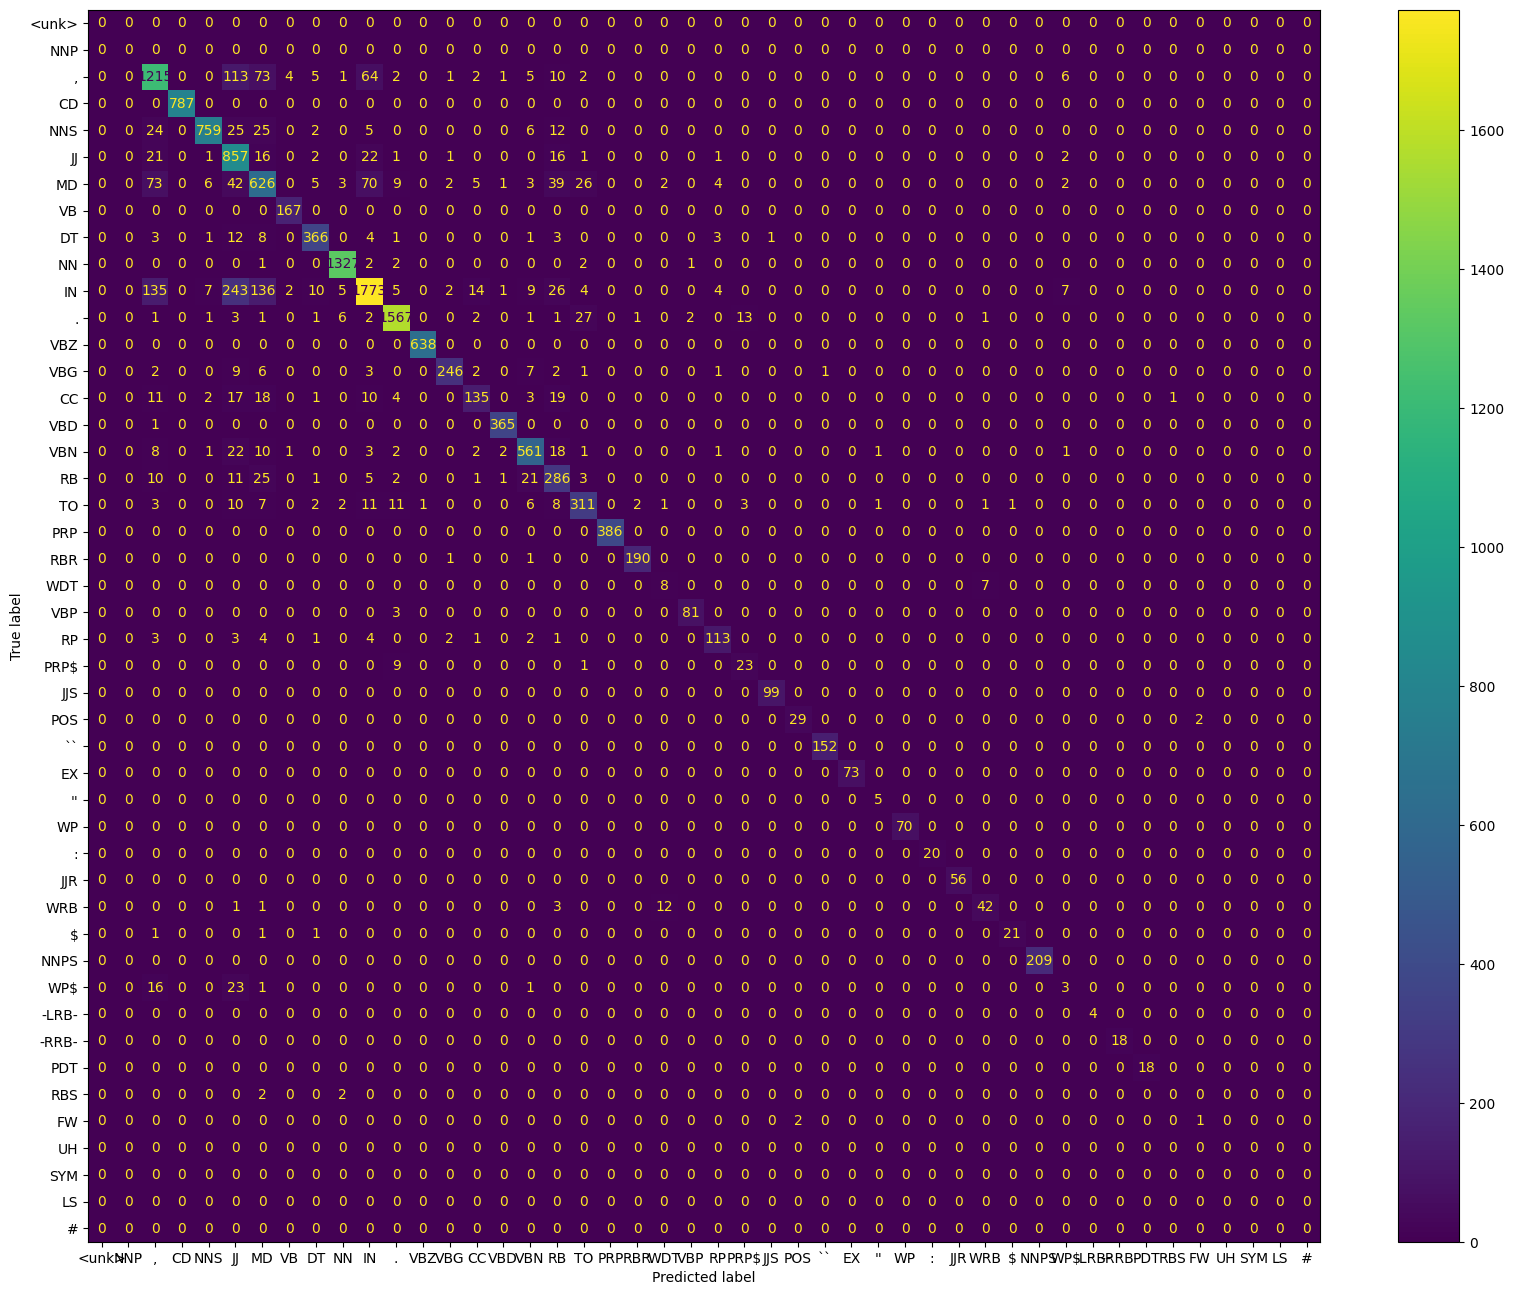

In [101]:
# conf_mat = confusion_matrix(ground_truth_test[ground_truth_test!=0].tolist(), pred_results_test[pred_results_test!=0].tolist())
fig, ax = plt.subplots(figsize=(20, 16))
ConfusionMatrixDisplay.from_predictions(ground_truth_test[ground_truth_test!=0].cpu(),
                                        pred_results_test[pred_results_test!=0].cpu(),
                                        labels= range(len(tag_listing)-1),
                                        display_labels= tag_listing[1:],
                                        ax= ax)
plt.show()
# print(confusion_matrix(ground_truth_test[ground_truth_test!=0].cpu(),
#                                         pred_results_test[pred_results_test!=0].cpu()))

In [ ]:
def error_map():


SyntaxError: ignored